In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import gluefactory
import torch
import faiss
from lightglue.utils import load_image
from evaluate_utils import Voting
from torch.nn.functional import cosine_similarity
from utils import process_image_into_patches, create_composite_image, draw_connections_with_numbers, draw_connections, downsample_descriptors, update_matches_for_downsampled_grid

In [18]:
# Parameters
imsize = 224
grid_rows, grid_cols = 4, 4 # it can be 16, 16 or 8, 8
gap_size = 20       # Gap around patches
gap_between_images = 50  # Gap between the two images
num_connections = 5  # Number of connections to draw
fontsize = 22

In [19]:
import os
import requests
import zipfile

url = "https://cmp.felk.cvut.cz/~weitong/vop/demo.zip"
local_zip_path = "demo.zip"
extract_path = "demo"

if not os.path.exists(extract_path + '/checkpoint_best.tar'):
    response = requests.get(url)
    with open(local_zip_path, 'wb') as file:
        file.write(response.content)
    
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    
    os.remove(local_zip_path)
    print(f"Successfully download {extract_path}!")
else:
    print(f"{extract_path} is ready!")

demo is ready!


In [20]:
# Load the images
image_path_1 = "demo/img0.jpg"
image1_plot = cv2.imread(image_path_1)
image1_plot = cv2.cvtColor(image1_plot, cv2.COLOR_BGR2RGB)

image_path_2 = "demo/img1.jpg"
image2_plot = cv2.imread(image_path_2)
image2_plot = cv2.cvtColor(image2_plot, cv2.COLOR_BGR2RGB)

assert image1_plot.shape == image2_plot.shape, "The two images must have the same shape"

patch_height = image1_plot.shape[0] // grid_rows  # Height of the patches
patch_width = image1_plot.shape[1] // grid_cols   # Width of the patches

In [21]:
# check if gpu device is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# use the trained model to encode the input embeddings
model = gluefactory.load_experiment('demo/checkpoint_best.tar').to(device).eval()

[12/07/2024 16:29:17 gluefactory.utils.experiments INFO] Loading checkpoint checkpoint_best.tar
Using cache found in /home/weitong/.cache/torch/hub/facebookresearch_dinov2_main


In [22]:
# precompute the patch-level and CLS tokens by pretrained Dino v2
image_1 = load_image(image_path_1, resize=imsize)
c, h, w = image_1.shape
image1 = torch.zeros((3, imsize, imsize), device=device, dtype=torch.float32)
image1[:, :h, :w] = image_1
feats1 = model.extractor({'image': image1[None]})
feats1['image_size'] = [list(image1.shape[1:])]

image_2 = load_image(image_path_2, resize=imsize)
c, h, w = image_2.shape
image2 = torch.zeros((3, imsize, imsize), device=device, dtype=torch.float32)
image2[:, :h, :w] = image_2
feats2 = model.extractor({'image': image2[None]})
feats2['image_size'] = [list(image2.shape[1:])]


In [23]:
data0 = {k+'0': torch.Tensor(feats1[k]) for k in feats1.keys()}
data1 = {k+'1': torch.Tensor(feats2[k])for k in feats2.keys()}
data = {**data0, **data1}

In [24]:
with torch.no_grad():
    pred = model.matcher({**data})

In [25]:
# get the embeddings
all_des = torch.concat([pred['desc0'], pred['desc1']])
cls_tokens = torch.concat([data['global_descriptor0'], data['global_descriptor1']])

In [26]:
# global score, on 1024 dim CLS tokens
cls_scores = torch.einsum('id,jd->ij', cls_tokens, cls_tokens)
cls_scores

tensor([[2146.9077, 1974.1693],
        [1974.1693, 2132.1282]])

In [27]:
# automatically choose a radius based on 100 random samples
torch.manual_seed(42)
random_indices = torch.randperm(all_des.size(0))[:100]
sample_des = all_des[random_indices]
similarities = cosine_similarity(sample_des.unsqueeze(2), sample_des.unsqueeze(1))
radius = round((torch.round(similarities.median() * 10) / 10).item(), 2)#torch.ceil(

In [28]:
radius

0.2

In [29]:
query_fun = Voting(radius, num_patches=all_des.shape[1])
retrieved = query_fun.query_each(all_des)
# voting score on patch descriptors
retrieved['scores'][0] if (retrieved['scores'][1]==0).all() else retrieved['scores'][1]

2it [00:00, 176.76it/s]


array([[  0.        , 545.99805105],
       [545.99805105,   0.        ]])

In [30]:
# matched patches by radius search
dim = pred['desc1'].shape[-1]
query_normalized = torch.nn.functional.normalize(pred['desc0'], dim=-1)
db_normalized = torch.nn.functional.normalize(pred['desc1'], dim=-1)
# radius search
index_flat_cpu = faiss.IndexFlatIP(dim)
# indexing all the patches in db images
index_flat_cpu.add(db_normalized.view(-1, dim).cpu().numpy().astype(np.float32))
lims, D_cpu, I_cpu = index_flat_cpu.range_search(query_normalized.view(-1, dim).cpu().numpy(), 1-radius)
for lims_i in range(len(lims)-1):
    sorted_idx = np.argsort(D_cpu[lims[lims_i]: lims[lims_i+1]])[::-1]
    if len(sorted_idx) > 0:
        D_cpu[lims[lims_i]: lims[lims_i+1]] = D_cpu[lims[lims_i]: lims[lims_i+1]][sorted_idx]
        I_cpu[lims[lims_i]: lims[lims_i+1]] = I_cpu[lims[lims_i]: lims[lims_i+1]][sorted_idx]
assignment, distance = [I_cpu[lims[idx]:lims[idx+1]] for idx in range(query_normalized.shape[1])], [1-D_cpu[lims[idx]:lims[idx+1]] for idx in range(query_normalized.shape[1])]


In [31]:
# get the indices for visualization
match_labels = np.array([(i, a[0]) for i, a in enumerate(assignment) if len(a)>0])
matches = update_matches_for_downsampled_grid(match_labels, (16, 16), (grid_rows, grid_cols))

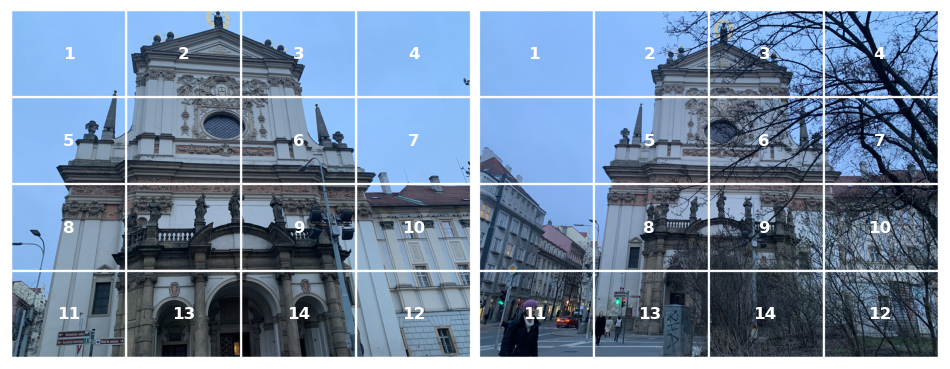

<Figure size 640x480 with 0 Axes>

In [32]:
# visualize the matched patches
descriptors1 = all_des[0]
descriptors2 = all_des[1]
# %%
orientation = "horizontal"    

# Process images into patches with gaps
processed_image1 = process_image_into_patches(image1_plot, patch_height, patch_width, gap_size)
processed_image2 = process_image_into_patches(image2_plot, patch_height, patch_width, gap_size)

# Create a composite image with a gap between the two processed images
composite_image = create_composite_image(processed_image1, processed_image2, gap_between_images, orientation=orientation)

# Draw connections between randomly selected patches
draw_connections_with_numbers(composite_image, matches, patch_height, patch_width, gap_size, gap_between_images, 12, orientation=orientation)